# Hamiltonian Simulation

## Overview

The goal in Hamiltonian simulation problems is to implement the map $H \mapsto \text{exp}(-i\tau H)$ for some Hermitian matrix $H$ (the Hamiltonian). Using QSP, we can reduce this problem to setting our target scalar function to $f(x) = \text{exp}(-i\tau x)$. Due to our parity constraint, the implementation of the target scalar function is separated into implementing components $f_{\text{Re}}(x) = \cos(\tau x)$ and $f_{\text{Im}}(x) = \sin(\tau x)$ respectively. These components can then be combined to realize $\text{exp}(-i\tau H)$ using linear combination of unitaries (LCU). To illustrate this workflow, we will choose $\tau = 100$.

In [1]:
tau = 100

opts = {
    'maxiter': 100,
    'criteria': 1e-12,
    'useReal': True,
    'method': 'Newton' # QSPPACK tutorial uses CM
}

## Solving for the real component

To increase the numerical stability, the real component of the target function is scaled down by a factor of $\frac{1}{2}$. This scaling causes the target function to be uniformly upper bounded by $\frac{1}{2}$. The Chebyshev coefficients of the target function are obtained by truncating the series to some finite degree, where it suffices to set $d=1.4|\tau|+\log\left( \frac{1}{\epsilon_0}\right)$ so that the truncation error is below $\epsilon_0$.

In [2]:
import numpy as np
from numpy.polynomial.chebyshev import chebinterpolate

# Define the target function
def targ(x):
    return 0.5 * np.cos(tau * x)

# Compute the degree for Chebyshev approximation
d = int(np.ceil(1.4 * tau + np.log(1e14)))+1
parity = d % 2

# Generate Chebyshev coefficients
xpts = np.cos(np.pi * (np.arange(d)+0.5) / d)
f_values = targ(xpts)
coef = chebinterpolate(targ, d)

# Discard coefficients of odd orders due to the even parity
print(f"Should be 0 due to even parity:\t{max(coef[parity+1::2])}")
coef_even = coef[parity::2]

Should be 0 due to even parity:	2.283887364943179e-17


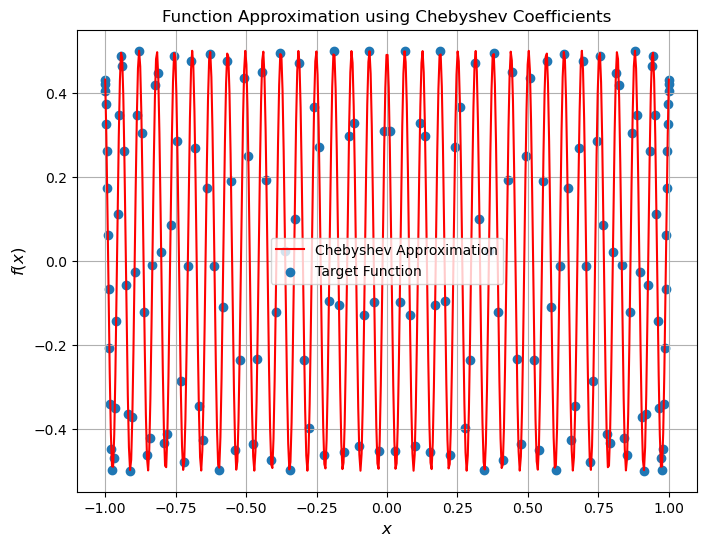

In [3]:
import matplotlib.pyplot as plt
from numpy.polynomial.chebyshev import chebval

# Define a range of x values for plotting
x_values = np.linspace(-1, 1, 500)

# Evaluate the Chebyshev polynomial at these x values
y_values = chebval(x_values, coef)

# Plot the function
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label='Chebyshev Approximation', color="red")
plt.scatter(xpts, f_values, label='Target Function')
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$f(x)$', fontsize=12)
plt.title('Function Approximation using Chebyshev Coefficients')
plt.legend()
plt.grid(True)
plt.show()


## Solving the phase factors and verifying

We can again use Newton's method to find the phase factors and verify the solution.

iter err          
   1  +1.7869e-01
   2  +1.8346e-03
   3  +1.4232e-07
Stop criteria satisfied.
The residual error is
5.850875339774575e-14


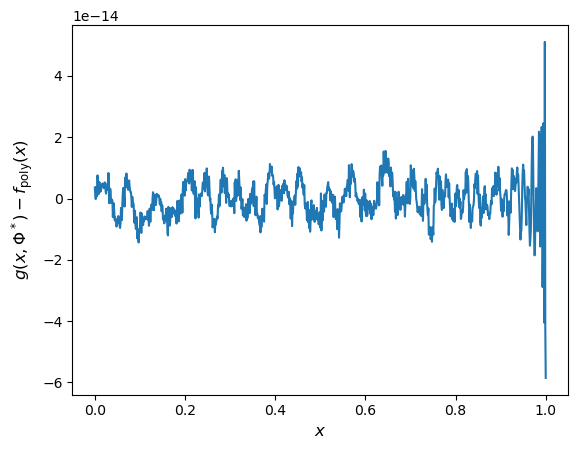

In [4]:
from optimization.QSP_solver import solve
phi_proc, out = solve(coef_even, parity, opts)

from optimization.utils import chebyshev_to_func
from optimization.core import get_entry
import matplotlib.pyplot as plt

xlist = np.linspace(0, 1, 1000)
targ_value = targ(xlist)
QSP_value = get_entry(xlist, phi_proc, out)
err = np.linalg.norm(QSP_value - targ_value, np.inf)
print('The residual error is')
print(err)

plt.plot(xlist, QSP_value - targ_value)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$g(x,\\Phi^*)-f_\\mathrm{poly}(x)$', fontsize=12)
plt.show()

## Reference
1. Low, G. H., & Chuang, I. L. (2017). Optimal Hamiltonian simulation by quantum signal processing. *Physical review letters*, 118(1), 010501.

2. Gilyén, A., Su, Y., Low, G. H., & Wiebe, N. (2019, June). Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics. In *Proceedings of the 51st Annual ACM SIGACT Symposium on Theory of Computing* (pp. 193-204).

3. Dong, Y., Meng, X., Whaley, K. B., & Lin, L. (2021). Efficient phase-factor evaluation in quantum signal processing. *Physical Review A*, 103(4), 042419.